<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/MI_detection_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI detection using PTB-XL with 12-leads and 10-fold CV



In [1]:
pip install wfdb

## STEP 1: Install necessary packages



In [2]:
!pip install wfdb scikit-learn matplotlib tensorflow --quiet


## STEP 2: Import required libraries


In [3]:
import os
import numpy as np
import pandas as pd
import wfdb
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## STEP 3: Load metadata and diagnostic class mapping

In [4]:
def load_ptbxl_metadata(path):
    data = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'))
    data.scp_codes = data.scp_codes.apply(lambda x: ast.literal_eval(x))
    return data

# Load SCP statements
def load_diagnostic_class_mapping(path):
    return pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)

## STEP 4: Apply MI vs Non-MI filter

In [5]:
def apply_diagnostic_filter(data, class_map):
    data['diagnostic_class'] = data.scp_codes.apply(
        lambda x: list(set([class_map.loc[k].diagnostic_class for k in x if k in class_map.index])))
    data['is_MI'] = data.diagnostic_class.apply(lambda x: 1 if 'MI' in x else 0)
    return data


## STEP 5: Load ECG signals

In [6]:
def load_raw_data(df, sampling_rate, path):
    data = []
    for i in range(len(df)):
        record_name = df.iloc[i].filename_lr if sampling_rate == 100 else df.iloc[i].filename_hr
        record_path = os.path.join(path, record_name)
        signal, _ = wfdb.rdsamp(record_path)
        data.append(signal)
    return np.array(data)

## STEP 6: Define ResNet-like model

In [10]:
def residual_block(x, filters, subsample):
    shortcut = x

    # Main path
    x = layers.Conv1D(filters, kernel_size=16, strides=subsample, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv1D(filters, kernel_size=16, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    # Ensure the shortcut shape matches the output shape of the main path
    if subsample > 1:
        shortcut = layers.Conv1D(filters, kernel_size=1, strides=subsample, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    elif x.shape[-1] != shortcut.shape[-1]:
         # If filters increase but subsample is 1, need to match filter size in shortcut
         shortcut = layers.Conv1D(filters, kernel_size=1, strides=1, padding='same')(shortcut)
         shortcut = layers.BatchNormalization()(shortcut)


    # Add
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_mi_resnet(input_shape=(1000, 12), num_classes=2): # Added num_classes argument
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, kernel_size=16, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)

    # Residual blocks with 4× subsampling and increasing filters
    # The subsample=4 might be too aggressive for 1000 time steps. Consider reducing subsample if needed.
    # For simplicity, keeping the original subsample=4 as in the user's code structure
    filters_list = [64, 128, 192, 256]
    subsamples = [4] * len(filters_list) # Apply subsample=4 for each block as per original loop structure
    # Ensure subsample is 1 for the first block if input and output channels match and no downsampling is needed.
    # Based on the original code, it seems the intention was subsampling in the residual blocks.
    # Let's keep subsample=4 but verify the input and output shapes of the blocks.

    for i, filters in enumerate(filters_list):
        # The first residual block's input is the output of the initial conv layer
        # Subsequent blocks take the output of the previous block
        subsample = subsamples[i]
        x = residual_block(x, filters=filters, subsample=subsample)


    x = layers.GlobalAveragePooling1D()(x)
    # Changed the final Dense layer to match the number of classes and use softmax activation
    x = layers.Dense(num_classes, activation='softmax')(x) # Changed to 2 units and softmax

    model = models.Model(inputs=inputs, outputs=x)

    # Keep binary_crossentropy as it works with one-hot for 2 classes
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', # This is correct for 2-class one-hot
                  metrics=['accuracy'])

    return model

## STEP 7: Main pipeline

In [9]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avvarusrinivasulu","key":"fe47c5051ef67f1130ff6e2e1fa439be"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Streaming output truncated to the last 5000 lines.
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19338_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19339_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19340_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.dat  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/19341_hr.hea  
  inflating: ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records500/19000/1934

In [8]:
ptbxl_path = '/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1'


# Prepare dataset
df = load_ptbxl_metadata(ptbxl_path)
scp_map = load_diagnostic_class_mapping(ptbxl_path)
scp_map = scp_map[scp_map.diagnostic_class.notnull()]
df['diagnostic_superclass'] = df.scp_codes.apply(lambda x: list(set([scp_map.loc[k].diagnostic_class for k in x if k in scp_map.index])))
df['MI'] = df.diagnostic_superclass.apply(lambda x: 1 if 'MI' in x else 0)

# Filter for 12-lead 10-sec ECGs
df_filtered = df[df['MI'].isin([0, 1])]


# Load ECG data (100Hz, 12 leads, 10 seconds)
X = load_raw_data(df_filtered, sampling_rate=100, path=ptbxl_path)
y = df_filtered['MI'].values
# print(np.shape(X1))
# X = X1[:, 0:, :12]

# Normalize
X = (X - np.mean(X)) / np.std(X)

# Convert labels to categorical
y_cat = to_categorical(y)

# Split data (60% train, 20% val, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.3, random_state=42, stratify=y)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0, random_state=42, stratify=y_temp)

## Model setup and Training

In [22]:
model = build_mi_resnet(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])


lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=7, verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=40,
          batch_size=32,
          callbacks=[lr_scheduler])

Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 470s 956ms/step - accuracy: 0.7615 - loss: 0.5178 - val_accuracy: 0.8130 - val_loss: 0.4245 - learning_rate: 0.0010
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 499s 950ms/step - accuracy: 0.8175 - loss: 0.3984 - val_accuracy: 0.7804 - val_loss: 0.4905 - learning_rate: 0.0010
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 498s 943ms/step - accuracy: 0.8345 - loss: 0.3670 - val_accuracy: 0.8127 - val_loss: 0.4185 - learning_rate: 0.0010
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 482s 901ms/step - accuracy: 0.8445 - loss: 0.3529 - val_accuracy: 0.8559 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 453s 925ms/step - accuracy: 0.8575 - loss: 0.3295 - val_accuracy: 0.8596 - val_loss: 0.3323 - learning_rate: 0.0010
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 490s 899ms/step - accuracy: 0.8623 - loss: 0.3219 - val_accuracy: 0.8466 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 7/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 459s 935ms/step - accura

## Testing the Model

In [23]:
# Evaluate on test set
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Confusion Matrix and Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true_labels, y_pred_labels))

# Save final model
model.save("mi_detection_resnet_model_v1.1.h5")

205/205 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      4906
           1       0.78      0.68      0.73      1646

    accuracy                           0.87      6552
   macro avg       0.84      0.81      0.82      6552
weighted avg       0.87      0.87      0.87      6552

Confusion Matrix:
[[4586  320]
 [ 528 1118]]


## Tetsing on PTB database

In [24]:
# STEP 1: Install dependencies
!pip install wfdb scikit-learn numpy matplotlib

import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib  # or from tensorflow.keras.models import load_model if deep learning


In [ ]:

# STEP 2: Download PTB Database (use PhysioNet mirror)
# !wget -r -N -c -np https://physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0/ -P ptb_data
# STEP 2: Download via WFDB API
wfdb.dl_database('ptbdb', dl_dir='ptb_data')



Generating record list for: patient001/s0010_re
Generating record list for: patient001/s0014lre
Generating record list for: patient001/s0016lre
Generating record list for: patient002/s0015lre
Generating record list for: patient003/s0017lre
Generating record list for: patient004/s0020are
Generating record list for: patient004/s0020bre
Generating record list for: patient005/s0021are
Generating record list for: patient005/s0021bre
Generating record list for: patient005/s0025lre
Generating record list for: patient005/s0031lre
Generating record list for: patient005/s0101lre
Generating record list for: patient006/s0022lre
Generating record list for: patient006/s0027lre
Generating record list for: patient006/s0064lre
Generating record list for: patient007/s0026lre
Generating record list for: patient007/s0029lre
Generating record list for: patient007/s0038lre
Generating record list for: patient007/s0078lre
Generating record list for: patient008/s0028lre
Generating record list for: patient008/s

In [15]:
import zipfile
import os

# Example: Path to your zip file
zip_path = "/content/ptb_data.zip"
extract_to = "/content/ptb_data"

# Create destination directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Unzipped to: {extract_to}")

Unzipped to: /content/ptb_data


In [17]:
# import os

# for root, dirs, files in os.walk("ptb_data"):
#     for name in files:
#         if name.endswith(".hea"):
#             print(os.path.join(root, name))

# STEP 3: Collect 12-lead .hea files
import glob
import wfdb

record_paths = sorted(glob.glob("ptb_data/content/ptb_data/patient*/**/*.hea", recursive=True))
print("Found", len(record_paths), "records")

Found 549 records


In [18]:
# STEP 4: Define helpers for reading, resampling, segmenting


def read_12lead_ecg(path):
    rec = wfdb.rdrecord(path[:-4])
    # picks 12 standard leads, ignoring Frank leads
    data = rec.p_signal[:, :12].T  # (12, n_samples)
    return data, rec

def resample_to_100Hz(arr, orig=1000, target=100):
    num = int(arr.shape[1] * target / orig)
    return resample(arr, num, axis=1)

def normalize(x): return (x - x.mean()) / x.std()


In [19]:
# STEP 5: Build test dataset
X_test, y_test = [], []

for p in record_paths:
    data, rec = read_12lead_ecg(p)
    r100 = resample_to_100Hz(data)
    seg = r100[:, :1000]  # 10 sec @ 100 Hz
    seg = normalize(seg)
    # Label extraction
    c = " ".join(rec.comments).lower()
    if "myocardial infarction" in c:
        y = 1
    elif "healthy" in c:
        y = 0
    else:
        continue
    X_test.append(seg); y_test.append(y)

X_test = np.array(X_test)  # (n,12,1000)
y_test = np.array(y_test)
print("Test data shape:", X_test.shape, "| Labels:", y_test.shape)



Test data shape: (448, 12, 1000) | Labels: (448,)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
Shape of y_pred_prob: (448, 2)
Classification Report:

              precision    recall  f1-score   support

      Normal       0.25      0.96      0.39        80
          MI       0.98      0.36      0.53       368

    accuracy                           0.47       448
   macro avg       0.61      0.66      0.46       448
weighted avg       0.85      0.47      0.50       448



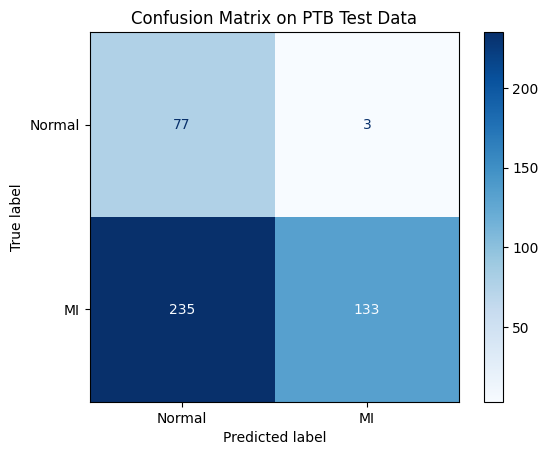

In [25]:
# STEP 6: Reshape if needed and load your trained model
# Example for sklearn or Keras model
# Reshape if your model needs (samples, features)

from tensorflow.keras.models import load_model

# Load model — adjust path as needed
# model = joblib.load("your_mi_model.pkl")  # Replace with your model path
model = load_model("mi_detection_resnet_model_v1.1.h5") # For Keras:

# STEP 7: Predict and evaluate
# Convert shape (N, 12, 1000) → (N, 1000, 12)
X_keras = np.transpose(X_test, (0, 2, 1))  # Time-first format

# Predict
y_pred_prob = model.predict(X_keras)

# If binary classification:
y_pred = np.argmax(y_pred_prob, axis=1)
print("Shape of y_pred_prob:", y_pred_prob.shape)
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "MI"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "MI"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on PTB Test Data")
plt.show()



In [21]:
# !zip -r /content/ptb_data.zip /content/ptb_data

## STEP 8: 5-Fold Cross-Validation

In [ ]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold = 1
# histories, reports = [], []

# for train_index, test_index in skf.split(X, y):
#     print(f"\n--- Fold {fold} ---")
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     model = build_resnet_model(X.shape[1:])
#     model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
#     early_stop = EarlyStopping(patience=5, restore_best_weights=True)

#     history = model.fit(X_train, y_train, epochs=30, batch_size=32,
#                         validation_split=0.2, callbacks=[early_stop], verbose=0)
#     histories.append(history)

#     y_pred = (model.predict(X_test) > 0.5).astype(int)
#     print(classification_report(y_test, y_pred))
#     cm = confusion_matrix(y_test, y_pred)
#     ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-MI', 'MI']).plot()
#     plt.title(f"Fold {fold} Confusion Matrix")
#     plt.show()
#     reports.append(classification_report(y_test, y_pred, output_dict=True))

#     # Save model from one fold for future testing
#     if fold == 1:
#         model.save('/content/mi_detector_resnet_fold1.h5')

#     fold += 1